In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib.pyplot import imshow
from models.vgg import Vgg16
import numpy as np
import os
from PIL import Image
import torch
from torch.autograd import Variable
import torchvision.models as models
from tqdm import tqdm

from attacks.dispersion import DispersionAttack_gpu
from utils.image_utils import load_image
from utils.torch_utils import numpy_to_variable

In [3]:
dataset_dir = "images"
outout_dir = "images_adv"
images_name = os.listdir(dataset_dir)

model = Vgg16()
internal = [i for i in range(29)]
# Initialize dipersion reduction attack
attack = DispersionAttack_gpu(model, epsilon=16./255, step_size=1./255, steps=1000)

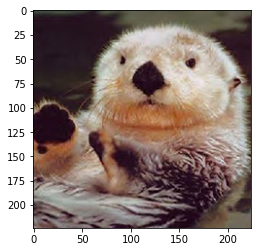

In [4]:
# Plot image
image = Image.open('./images/example.png')
imshow(image)

  0%|          | 0/2 [00:00<?, ?it/s]/home/yantaolu/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
 50%|█████     | 1/2 [00:17<00:17, 17.24s/it]

original_label:285, adv_label:669


100%|██████████| 2/2 [00:35<00:00, 17.75s/it]

original_label:356, adv_label:78


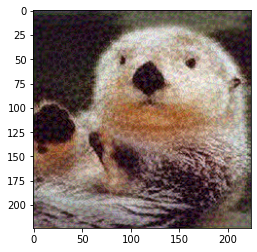

In [5]:

for idx, temp_image_name in enumerate(tqdm(images_name)):
    temp_image_path = os.path.join(dataset_dir, temp_image_name)
    image_np = load_image(data_format='channels_first', abs_path=True, fpath=temp_image_path)
    image = numpy_to_variable(image_np)
    original_label = np.argmax(model.model(image).detach().cpu().numpy())
    adv = attack(image, 
                 attack_layer_idx=14, 
                 internal=internal, 
                )
    adv_image = (np.transpose(adv[0].cpu().numpy(), (1, 2, 0)) * 255).astype(np.uint8)
    adv_image = Image.fromarray(adv_image)
    adv_image.save(os.path.join(outout_dir, temp_image_name))
    imshow(adv_image)
    adv = Variable(torch.tensor(adv), requires_grad=True)
    adv_label = np.argmax(model.model(adv).detach().cpu().numpy())
    print('original_label:%d, adv_label:%d' % (original_label, adv_label))

In [6]:
import torchvision
dataset_dir = "./"

dataset_dir_ori = os.path.join(dataset_dir, 'images')
dataset_dir_adv = os.path.join(dataset_dir, 'images_adv')

images_name = os.listdir(dataset_dir_ori)

test_model = torchvision.models.densenet121(pretrained='imagenet').cuda().eval()

for idx, temp_image_name in enumerate(tqdm(images_name)):
    total_samples = len(images_name)
    ori_img_path = os.path.join(dataset_dir_ori, temp_image_name)
    adv_img_path = os.path.join(dataset_dir_adv, temp_image_name)

    image_ori_np = load_image(data_format='channels_first', shape=(224, 224), bounds=(0, 1), abs_path=True, fpath=ori_img_path)
    image_ori_var = numpy_to_variable(image_ori_np)
    gt_out = test_model(image_ori_var).detach().cpu().numpy()
    gt_label = np.argmax(gt_out)
    
    image_adv_np = load_image(data_format='channels_first', shape=(224, 224), bounds=(0, 1), abs_path=True, fpath=adv_img_path)
    image_adv_var = numpy_to_variable(image_adv_np)
    pd_out = test_model(image_adv_var).detach().cpu().numpy()
    pd_label = np.argmax(pd_out)

    print('idx: ', idx)
    print('ground truth: ', gt_label)
    print('prediction: ', pd_label)

100%|██████████| 2/2 [00:00<00:00, 11.32it/s]

idx:  0
ground truth:  285
prediction:  281
idx:  1
ground truth:  356
prediction:  296
